# Mapping of HLCA extension datasets to the HLCA core using scArches

Here we'll map all the datasets from the HLCA extension to the HLCA core, by using [scArches](https://www.nature.com/articles/s41587-021-01001-7). As a basis model for the mapping, we'll use the model that was generated by scANVI for integration of the core datasets.
Note that we use scArches version 0.3.5 and scvi tools version 0.8.1 here.

# Mapping of atlas extensions datasets to the HLCA core

Here we map the datasets from the extension to the HLCA core one by one, using scArches. 

### Import modules, set paths, load files:

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import os

In [3]:
import scarches as sca

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

for code formatting, if wanted:

In [4]:
%load_ext lab_black

set figure params, if wanted:

In [5]:
sc.set_figure_params(dpi=120, figsize=(4, 4))

set paths:

In [ ]:
path_input_core_data = "../../data/HLCA_core_h5ads/HLCA_v1_integration/HLCA_v1_scANVI_input.h5ad"
path_input_extension_data = "../../data/HLCA_extended/HLCA_extended/extension_data_pooled_raw_2000genes.h5ad"
dir_reference_model = '../../results/scANVI_integration/scanvi_model' # directory where the reference model is stored
dir_surgery_models = '../../data/HLCA_extended/HLCA_extended_models_and_embs/surgery_models' # directory where surgery model(s) will be stored
dir_surgery_embs = "../../data/HLCA_extended/HLCA_extended_models_and_embs/surgery_output_embeddings"

set relevant adata.obs labels to use for integration:

In [11]:
condition_key = 'dataset'
cell_type_key = 'scanvi_label'
unlabeled_category = "unlabeled"

## Import reference adata (atlas, raw):

In [4]:
reference_adata = sc.read(path_input_core_data)

In [5]:
reference_adata.shape

(587218, 2000)

In [6]:
reference_adata.var.head(5)

,gene_symbols,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
ENSG00000000938,FGR,107870,True,0.203495,1.104081,2.025088,5,False
ENSG00000000971,CFH,113428,True,0.188413,1.086728,2.930069,7,False
ENSG00000002587,HS3ST1,82919,True,0.158216,1.075575,2.524420,8,False
ENSG00000002933,TMEM176A,36999,True,0.061320,1.334051,6.511887,11,False
ENSG00000003436,TFPI,136851,True,0.270989,1.222142,3.246769,8,False


set var index to gene symbols instead of ensembl IDs:

In [7]:
reference_adata.var["gene_ids"] = reference_adata.var.index.tolist()
reference_adata.var.index = reference_adata.var.gene_symbols.values
reference_adata.var.drop(columns="gene_symbols", inplace=True)

In [10]:
reference_adata.var.head(5)

,n_cells,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection,gene_ids
FGR,107870,True,0.203495,1.104081,2.025088,5,False,ENSG00000000938
CFH,113428,True,0.188413,1.086728,2.930069,7,False,ENSG00000000971
HS3ST1,82919,True,0.158216,1.075575,2.524420,8,False,ENSG00000002587
TMEM176A,36999,True,0.061320,1.334051,6.511887,11,False,ENSG00000002933
TFPI,136851,True,0.270989,1.222142,3.246769,8,False,ENSG00000003436


plot cell type labels that were used for scANVI integration:

In [11]:
sc.set_figure_params(figsize=(8,8))

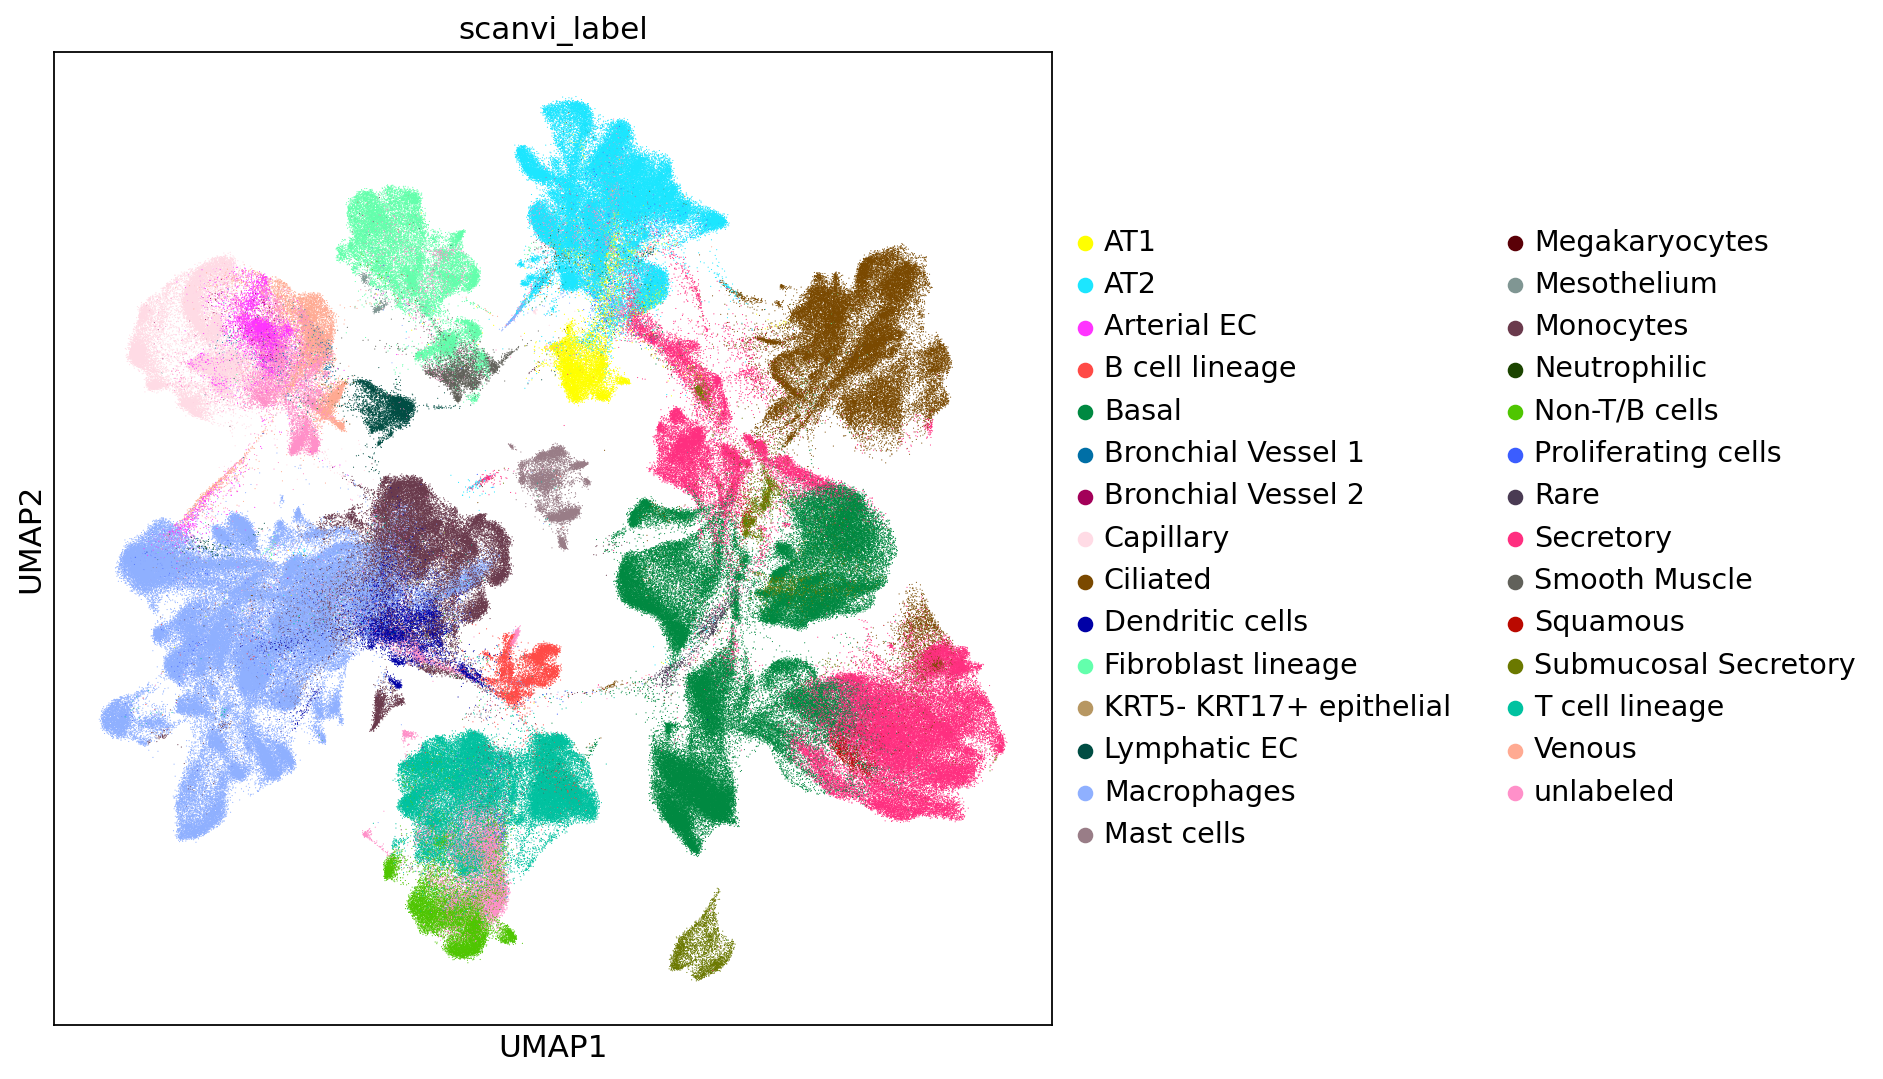

In [12]:
sc.pl.umap(reference_adata,color='scanvi_label',size=1)

# Import query data:

i.e. data to be mapped

In [12]:
query_adata = sc.read_h5ad(path_input_extension_data)

In [13]:
query_adata

AnnData object with n_obs × n_vars = 1647652 × 2000
    obs: 'dataset', 'study', 'original_celltype_ann', 'condition', 'subject_ID', 'sample', 'cells_or_nuclei', 'single_cell_platform', 'sample_type', 'age', 'sex', 'ethnicity', 'BMI', 'smoking_status', 'anatomical_region_level_1', 'anatomical_region_coarse', 'anatomical_region_detailed', 'genome', 'disease'

sort genes in the same order as the reference adata:

In [14]:
query_adata = query_adata[:, reference_adata.var.index].copy()

In [15]:
query_adata

AnnData object with n_obs × n_vars = 1647652 × 2000
    obs: 'dataset', 'study', 'original_celltype_ann', 'condition', 'subject_ID', 'sample', 'cells_or_nuclei', 'single_cell_platform', 'sample_type', 'age', 'sex', 'ethnicity', 'BMI', 'smoking_status', 'anatomical_region_level_1', 'anatomical_region_coarse', 'anatomical_region_detailed', 'genome', 'disease'

In [16]:
query_adata.var.head(5)

""
FGR
CFH
HS3ST1
TMEM176A
TFPI


# Set relevant layers to raw counts: 

already done for reference:

In [17]:
reference_adata.X[:10,:10].toarray()

array([[0., 3., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 2., 3., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]], dtype=float32)

In [18]:
reference_adata.raw.X[:10,:10].toarray()

array([[0., 3., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 2., 3., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]], dtype=float32)

### set .Raw to counts:

if data are raw counts already, create a raw layer as follows:

In [19]:
query_adata.raw = query_adata
raw = query_adata.raw.to_adata()
raw.X = query_adata.X
query_adata.raw = raw

quick check if X and raw.X have integers:

In [20]:
query_adata.raw.X[:10,:10].toarray()

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 8., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [21]:
query_adata.X[:10,:10].toarray()

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 8., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

set cell type key to unlabeled:

In [22]:
query_adata.obs[cell_type_key] = unlabeled_category

In [23]:
reference_adata.obs.dataset.unique()

['Teichmann_Meyer_2019', 'Misharin_Budinger_2018', 'Krasnow_2020', 'Seibold_2020_10Xv3', 'Banovich_Kropski_2020', ..., 'Lafyatis_Rojas_2019_10Xv1', 'Lafyatis_Rojas_2019_10Xv2', 'Meyer_2019', 'Jain_Misharin_2021_10Xv2', 'Jain_Misharin_2021_10Xv1']
Length: 14
Categories (14, object): ['Teichmann_Meyer_2019', 'Misharin_Budinger_2018', 'Krasnow_2020', 'Seibold_2020_10Xv3', ..., 'Lafyatis_Rojas_2019_10Xv2', 'Meyer_2019', 'Jain_Misharin_2021_10Xv2', 'Jain_Misharin_2021_10Xv1']

### Perform surgery on reference model and train on query dataset without cell type labels

set params:

In [27]:
query_conditions = [ds for ds in query_adata.obs.dataset.unique().tolist() if ds not in reference_adata.obs.dataset.unique()]
surgery_epochs = 500
early_stopping_kwargs_surgery = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "on": "full_dataset",
    "patience": 10,
    "threshold": 0.001,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

In [20]:
query_conditions = [
    ds
    for ds in query_adata.obs.dataset.unique().tolist()
    if ds not in reference_adata.obs.dataset.unique()
]

check if query conditions are as expected (these should be the added datasets/batches)

In [22]:
len(query_conditions)

32

Now perform the mapping and store the results:

In [ ]:
for condition in query_conditions[::-1]: # (going from small to large dataset, to see quickly if code is working)
    print(condition)
    query_subadata = query_adata[query_adata.obs.dataset == condition,:].copy()
    print(query_subadata.shape)
    # load model and set relevant variables:
    model = sca.models.SCANVI.load_query_data(
        query_subadata,
        dir_reference_model,
        freeze_dropout = True,
    )
    model._unlabeled_indices = np.arange(query_subadata.n_obs)
    model._labeled_indices = []
    print("Labelled Indices: ", len(model._labeled_indices))
    print("Unlabelled Indices: ", len(model._unlabeled_indices))
    # now train surgery model using reference model and query adata
    model.train(
        n_epochs_semisupervised=surgery_epochs,
        train_base_model=False,
        semisupervised_trainer_kwargs=dict(metrics_to_monitor=["accuracy", "elbo"], 
                                           weight_decay=0,
                                           early_stopping_kwargs=early_stopping_kwargs_surgery
                                          ),
        frequency=1
    )
    surgery_path = os.path.join(dir_surgery_models, condition)
    if not os.path.exists(surgery_path):
        os.makedirs(surgery_path)
    model.save(surgery_path, overwrite=True)

Lambrechts_2021
(65166, 2000)
WARNING  var_names for adata passed in does not match var_names of adata used to train the   
         model. For valid results, the vars need to be the same and in the same order as the 
         adata used to train the model.                                                      
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 65166 cells, 2000 vars, 15        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Labelled Indices:  0
Unlabelled Indices:  65166
INFO     Training Unsupervised Trainer for 123 epochs.                      

to reload specific models, use the following code:

In [ ]:
# model = sca.models.SCANVI.load_query_data(query_adata, 'surgery_model', freeze_dropout=True) # this is before training

In [ ]:
# model = sca.models.SCANVI.load(surgery_path,query_adata) # if already trained

### Get latent representation of (reference +) query dataset:

(same as before)

In [25]:
query_conditions = [
    ds
    for ds in query_adata.obs.dataset.unique().tolist()
    if ds not in reference_adata.obs.dataset.unique()
]

Get embeddings (for query dataset only, not combined with reference because should be the same every time) and store:

In [26]:
for dataset in query_conditions[::-1]: # from small to large datasets
    print(f"Working on {dataset}...")
    query_subadata = query_adata[query_adata.obs.dataset == dataset,:].copy()
    surgery_path = os.path.join(dir_surgery_models, dataset)
    model = sca.models.SCANVI.load(surgery_path,query_subadata)
    query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
    query_subadata_latent.obs.index = query_subadata.obs.index
    query_subadata_latent.write(os.path.join(dir_surgery_embs, f"{dataset}_emb.h5ad"))

Working on Lambrechts_2021...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 65166 cells, 2000 vars, 15        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Working on Sun_2020_batch4...
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 16854 cells, 2000 vars, 15        


get embeddings for newly added cells from datasets already present in the LCA (i.e. reference); for these "extensions" of datasets in the core we did not learn any adapters/do any surgery.

## LISA CHECK IF IT USES THE CORRECT BATCH ONE-HOT ENCODING HERE...

In [29]:
for dataset in query_adata.obs.dataset.unique():
    if dataset not in query_conditions:
        print(f"Working on {dataset}...")
        query_subadata = query_adata[query_adata.obs.dataset == dataset,:].copy()
        model = sca.models.SCANVI.load(dir_reference_model,query_subadata)
        query_subadata_latent = sc.AnnData(model.get_latent_representation(adata=query_subadata))
        query_subadata_latent.obs.index = query_subadata.obs.index
        query_subadata_latent.write(f"../scArches_models/surgery_output_embeddings/{dataset}_emb_LCAv2_no_surgery.h5ad")

Working on Banovich_Kropski_2020...
WARNING  var_names for adata passed in does not match var_names of adata used to train the   
         model. For valid results, the vars need to be the same and in the same order as the 
         adata used to train the model.                                                      
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 82692 cells, 2000 vars, 14        
         batches, 29 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
Working on Misharin_Budinger_2018...
WARNING  var_names for adata passed in does not match var_names of adata used to 

Query and reference combined:

....select dataset of interest (name and matching query adata subset)....

#### THIS CODE IS WRONG, USING THE REFERENCE MODEL HERE TO GET THE LATENT REPRESENTATION OF QUERY DATASETS!!!! NEED TO CORRECT FOR REVISIONS!!!

commented out all faulty code now

In [ ]:
# # concatenate reference and query data
# adata_full = reference_adata.concatenate(query_adata, index_unique=None) #, batch_key=None, batch_categories=None)
# # run through model
# full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
# # copy indices (order is retained)
# full_latent.obs.index = adata_full.obs.index
# # copy cell type labels
# full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
# # copy batch labels
# full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()
# # # if wanted, copy reference annotation labels, level 1 - 5:
# # for lvl in range(1,6):
# #     lvl_name = "ann_level_" + str(lvl)
# #     # initiate empty columns
# #     full_latent.obs[lvl_name] = None
# #     # fill in 
# #     full_latent.obs.loc[reference_adata.obs.index, lvl_name]= reference_adata.obs[lvl_name]
# #     if lvl_name in query_adata.obs.columns:
# #         full_latent.obs.loc[query_adata.obs.index, lvl_name] = query_adata.obs[lvl_name]
# #     else:
# #         print("filling out 'None' for {} in query_adata".format(lvl_name))
# #         full_latent.obs.loc[query_adata.obs.index, lvl_name] = None

Store:

In [ ]:
if not os.path.exists(f"{data_dir}query_datasets/out/{query_adata_name}"):
    os.makedirs(f"{data_dir}query_datasets/out/{query_adata_name}")

store embedding:

In [ ]:
# full_latent.write(f"{data_dir}query_datasets/out/{query_adata_name}/HLCA_{query_adata_name}_emb.h5ad")

store full adata, if wanted:

In [ ]:
# adata_full.obsm['X_scarches_emb'] = full_latent.X

In [ ]:
# adata_full.write(f"{data_dir}query_datasets/out/{query_adata_name}/HLCA_{query_adata_name}_adata.h5ad")